# Introduction
In Part I, we collected data for S&P 500 for analysis. In Part II, you might be expecting to jump straight to LSTM for price prediction.

You could do that, but what is time-series data analysis in a project without a bit of ARIMA? You won't find this section in the original research paper, but we here at UpLevel like to go the extra mile for you <3

In this Part, here's what we're going to do:
1. Load our dataset and libraries
2. Prepare our data via upsampling and backfilling
3. Identify the p, d, and q terms for our ARIMA model through statistical and visual methods
4. Train an ARIMA model
5. Compare the model predictions and actual test data

Joke aside, this Part is actually quite tough because if you're not used to statistics or ARIMA you might struggle a bit. 

<strong><font color="red">We don't usually say this, but we'd like to emphasize that this Part is entirely optional.</font></strong>

### Quick intro to ARIMA
Auto Regressive Integrated Moving Average, or ARIMA for short, is a forecasting model for time-series data. 

ARIMA is composed of three components:
1. AR - AutoRegression
2. I - Integrated
3. MA - Moving Average

The ARIMA model models three aspects of a time series: seasonality (how cyclical pattern is), trend (which direction is the plot moving towards over time), and noise (how much random variability there is in the data). 

These aspects are represented by the parameters <em>p</em>, <em>d</em>, and <em>q</em>.

- p: number of non-regressive terms (for AR)
- d: number of non-seasonable differences (for I)
- q: number of moving average terms (for MA)

Ideally, we must transform our time series such that it remains stationary, i.e. hover around 0. Removing trends and seasonality makes modelling easier and more accurate.

More readings:
- <strong>General reading</strong>: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7 (use Incognito if you don't have a Medium account)
- <strong>For differencing/I term</strong>: https://people.duke.edu/~rnau/411arim2.htm
- <strong>For AR and MA terms</strong>: https://people.duke.edu/~rnau/411arim3.htm

Of course, we can't use ARIMA alone for stock prices only but this dataset is a good canvas for you to try this technique on. 

In addition, we're doing this Part so that we have contrasting results to our LSTM results in the subsequent Parts.

### Step 1: Import libraries
Before we start, let's import a few libraries.
- pandas as pd
- matplotlib.pyplot as plt

We'll import the other libraries we need later.

In [ ]:
# Step 1: Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Step 2: Read S&P 500 CSV as DataFrame
Let's read the CSV data as a DataFrame. 

Make sure the dates are the index, and that your parse_dates parameter is set to True.

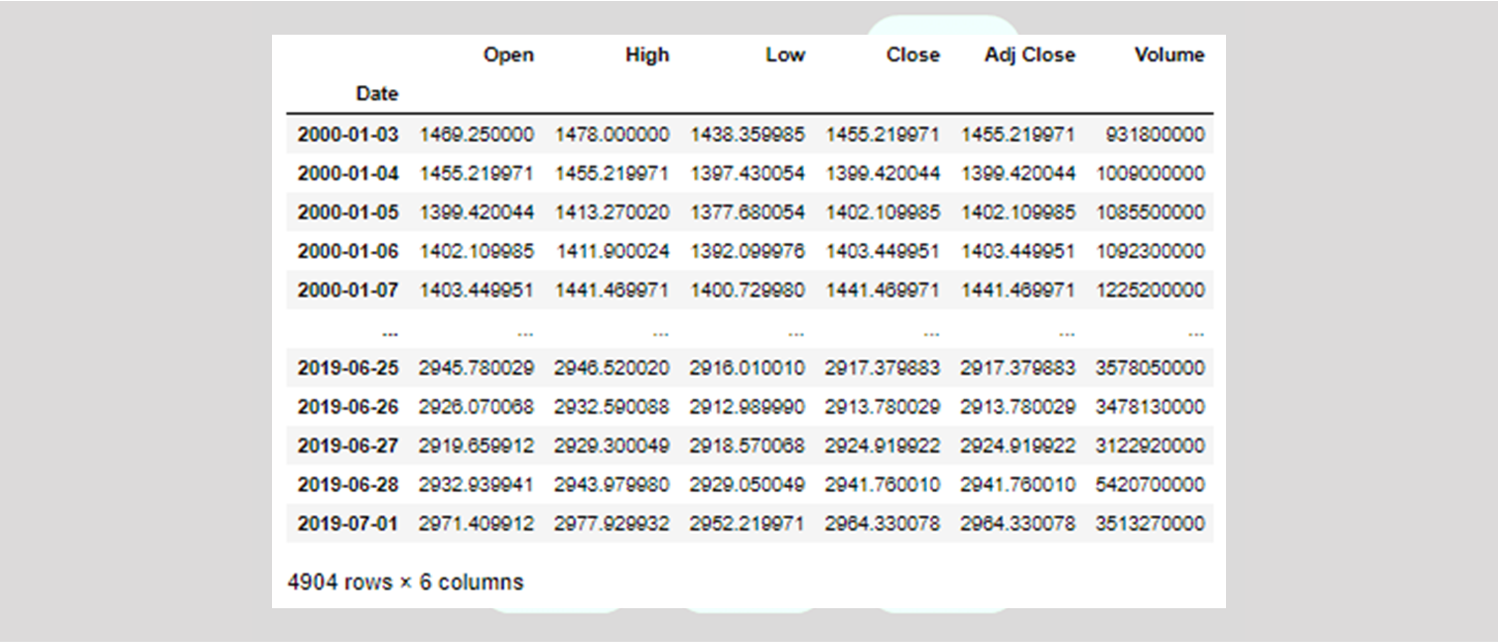

Sanity check:
- 4,904 rows
- 6 columns

In [ ]:
# Step 2: Read the S&P 500 CSV as DataFrame

In [7]:
df_sp500=pd.read_csv("sp500_final.csv",index_col='Date',parse_dates=True)

In [11]:
df_sp500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
...,...,...,...,...,...,...
2019-06-25,2945.780029,2946.520020,2916.010010,2917.379883,2917.379883,3578050000
2019-06-26,2926.070068,2932.590088,2912.989990,2913.780029,2913.780029,3478130000
2019-06-27,2919.659912,2929.300049,2918.570068,2924.919922,2924.919922,3122920000


In [8]:
df_sp500.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4904.000000,4904.000000,4904.000000,4904.000000,4904.000000,4.904000e+03
mean,1537.388434,1546.217755,1527.850651,1537.568960,1537.568960,3.081563e+09
std,544.356502,545.032494,543.595289,544.450875,544.450875,1.487788e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.560700e+08
25%,1145.967468,1154.517517,1138.567505,1146.100006,1146.100006,1.647075e+09
50%,1349.584961,1357.604981,1337.540039,1349.734985,1349.734985,3.209655e+09
75%,1930.855042,1943.154968,1917.095001,1930.837524,1930.837524,3.921070e+09
max,2971.409912,2977.929932,2952.219971,2964.330078,2964.330078,1.145623e+10


In [9]:
df_sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

### Step 3: Plot the DataFrame's 'Open'
We'll visualize the open price for S&P 500. 

Just go ahead and plot using matplotlib.pyplot. If you parsed your date properly when reading the CSV, you shouldn't encounter too much trouble here. 

In [ ]:
# Step 3: Plot 'Open'

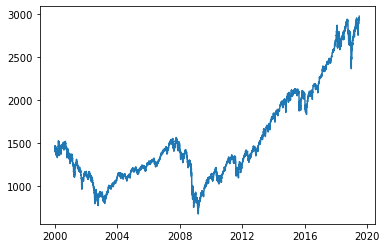

In [12]:
plt.plot(df_sp500['Open'])

## Data preparation

### Step 4: Fill in the missing dates
Time to prepare our dataset for ARIMA modelling. Our current dataset does not have continuous dates in the index because the prices are only available on weekdays. 

To fill in missing dates, we will use the .asfreq method and pass through the 'D' frequency into it, along with an interpolate method to fill the missing values in other columns.

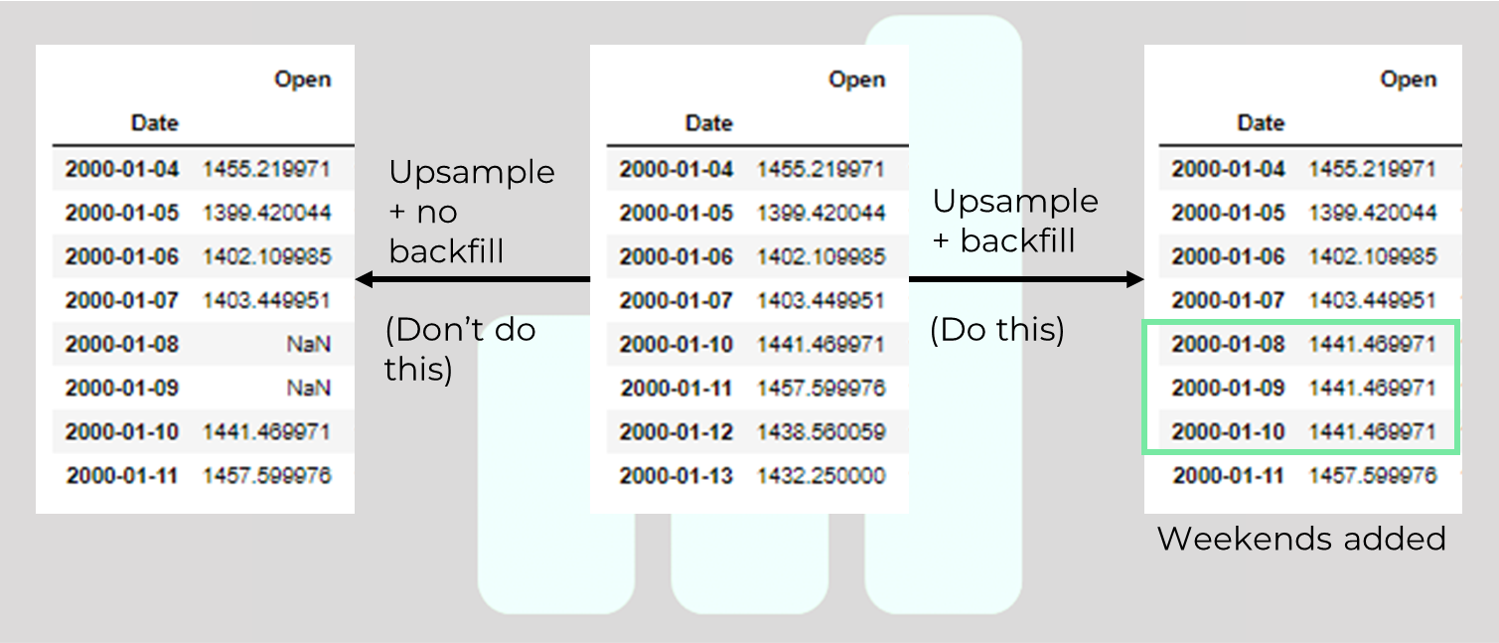

The resulting DataFrame should have:
- 7,120 rows
- 7 columns

Why backfill and not interpolate? You can do both, but our intuitive reasoning is that the prices from Friday remain the same throughout the weekend and changes only on Monday.

Readings: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.asfreq.html

In [ ]:
# Step 4a: Call asfreq with 'D', with backfill

In [13]:
df_sp500_filled=df_sp500.asfreq(freq='D', method='bfill')

In [14]:
df_sp500_filled

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000
...,...,...,...,...,...,...
2019-06-27,2919.659912,2929.300049,2918.570068,2924.919922,2924.919922,3122920000
2019-06-28,2932.939941,2943.979980,2929.050049,2941.760010,2941.760010,5420700000
2019-06-29,2971.409912,2977.929932,2952.219971,2964.330078,2964.330078,3513270000


### Step 5: Plot 'Open' from the new DataFrame
Let's take a look at our new DataFrame and plot the 'Open'. 

Compare the resulting with the plot from Step 3. Has the shape changed?

In [ ]:
# Step 5: Plot 'Open' from the new DataFrame

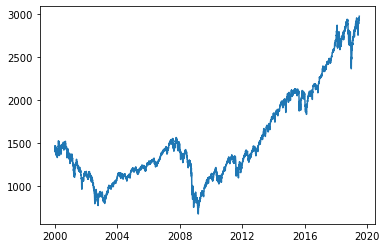

In [16]:
plt.plot(df_sp500_filled['Open'])

<details>
    <summary><font color = 'green'>Has the plot changed?</font></summary>
    <div>
        <strong>Nope it looks the same!</strong>
    </div>
</details>

## Determining the lag term (d)
Looks like the data is not stationary from the plot. As mentioned, we will need to turn our time-series trend into a straight line that oscillates around y=0.

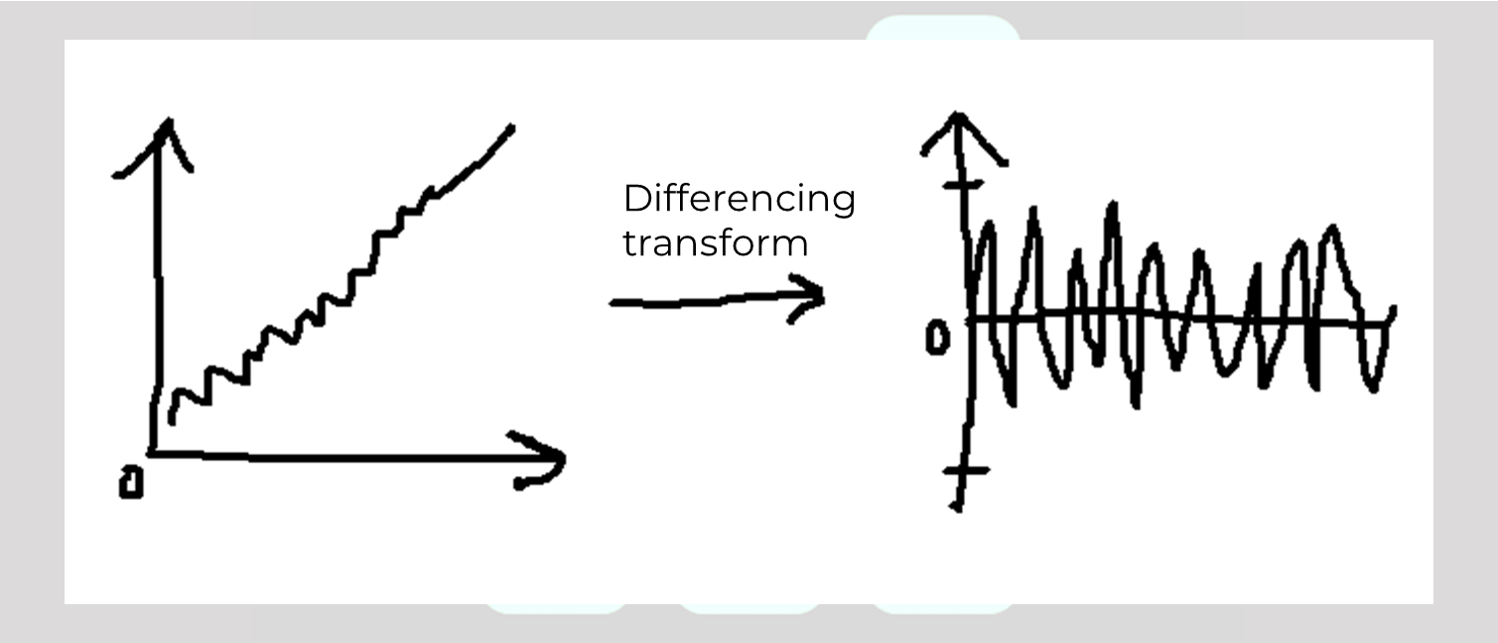

Differencing is taking the difference between one time period and the previous time period. For example:

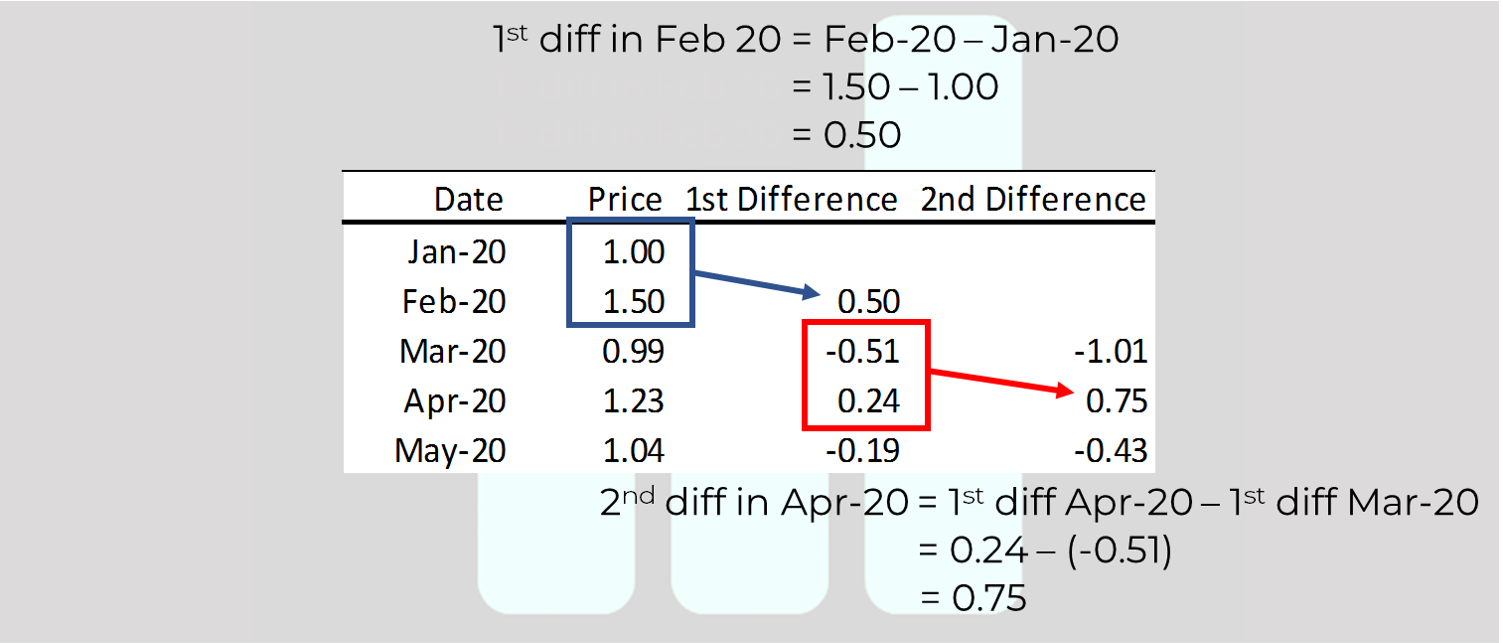

In this section, we figure the value of d, which is the lag term. Once we discover the lag term, we can then move on to getting the p and q terms. 

If we get a stationary plot after the first difference, then d=1. However, if we get a stationary plot only after the second difference, then d=2.

### Step 6: Create a column named first_diff
Create a new column called 'first_diff', that contains the difference between the current Open price and the previous timeframe's Open.

The first row will contain an NA, so don't forget to remove the first row after getting the difference. 

<details>
    <summary><font color = 'green'>Click once for hint</font></summary>
    <div>
        <strong>Google "get difference pandas"</strong>
    </div>
</details>

<details>
    <summary><font color = 'green'>Click here once after you are done to check if you got the same DataFrame</font></summary>
    <div>
        <img src = 'https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/FirstDiffDataFrame.png'>
    </div>
    <div>
        <p><strong>Don't forget to remove the first row that contains NA</strong></p>
    </div>
</details>

In [ ]:
# Step 6: Create a new column named "first_diff"

In [17]:
df_sp500_filled['first_diff']=df_sp500_filled['Open'].diff()

In [19]:
df_sp500_filled.dropna(inplace=True)

In [20]:
df_sp500_filled

,Open,High,Low,Close,Adj Close,Volume,first_diff
Date,,,,,,,
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-14.030029
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,-55.799927
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,2.689941
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1.339966
2000-01-08,1441.469971,1464.359985,1441.469971,1457.599976,1457.599976,1064800000,38.020020
...,...,...,...,...,...,...,...
2019-06-27,2919.659912,2929.300049,2918.570068,2924.919922,2924.919922,3122920000,-6.410156
2019-06-28,2932.939941,2943.979980,2929.050049,2941.760010,2941.760010,5420700000,13.280029
2019-06-29,2971.409912,2977.929932,2952.219971,2964.330078,2964.330078,3513270000,38.469971


### Step 7: Plot first_diff
Now that we've obtained the first difference, i.e. d=1, we now can plot first_diff and assess whether the plot is stationary. 

We anticipate a plot containing values that oscillate around y=0.

In [ ]:
# Step 7: Plot first_diff

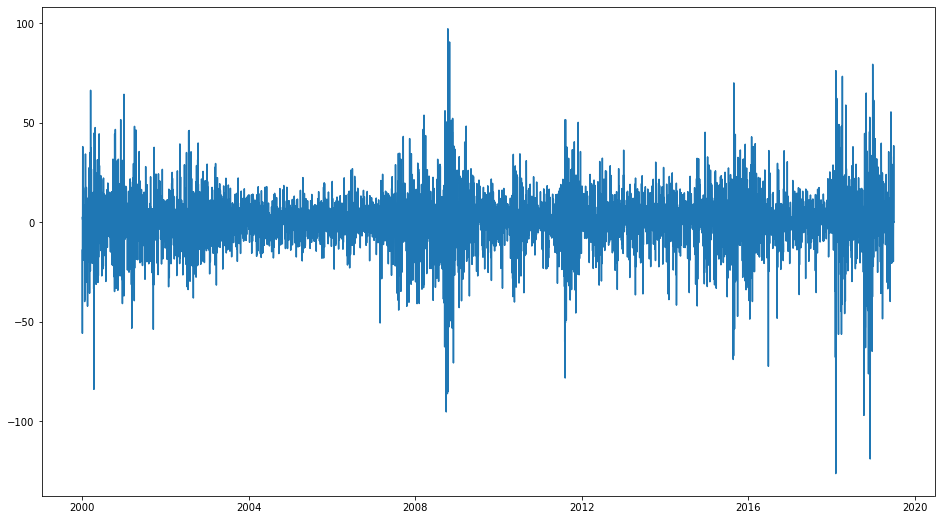

In [22]:
plt.figure(figsize = (16, 9))
plt.plot(df_sp500_filled['first_diff'])

### Use Augmented Dickey Fuller Test to test for stationary nature
Visually, it looks like the plot of first_diff is stationary. 

However, how can we truly tell that our plot is stationary? We use a statistical test called Augmented Dickey Fuller Test. 

The null hypothesis is that the plot is not stationary. The alternative hypothesis is that the plot is stationary. 

When we conduct the test, and the p-value is less than 0.05, we can reject the null hypothesis, i.e. the time series is stationary.

### Step 8: Import adfuller
We'll use statsmodels library for this. Import adfuller from statsmodels.tsa.stattools.

In [ ]:
# Step 8: Import adfuller

In [24]:
from statsmodels.tsa.stattools import adfuller 

### Step 9: Use adfuller with 'first_df' column data
Now that you've imported adfuller, use it on first_df data.

You'll get a tuple containing a few things so head on to the documentation identify the particular entry in the tuple that is your p-value, and assess whether we reject or fail to reject the null hypothesis.

Reference: https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

In [ ]:
# Step 9: Use adfuller on 'first_df'

In [25]:
first_df = df_sp500_filled['first_diff']
result = adfuller(first_df)

In [27]:
print('p-value: %f' % result[1])

p-value: 0.000000


<details>
    <summary><font color = 'green'>Is our first_diff stationary? (Click once to find out)</font></summary>
    <div>
        <strong>Yes, because you should expect a p-value of less than 0.05 so we can reject the null hypothesis that the time-series is not stationary.</strong>
    </div>
</details>

### [Optional] Use adfuller with 'Open' column data
Try using adfuller with 'Open' column values as well and see what the p-value is.

Before you plot try to imagine what the p-value will be for the 'Open' data, i.e. is it more or less than 0.05?

In [ ]:
# Test 'Open' column with adfuller

In [28]:
open_df = df_sp500_filled['Open']
result_open = adfuller(open_df)

In [29]:
print('p-value: %f' % result_open[1])

p-value: 0.993948


To conclude, we found our d value when fitting our 'Open' data later. 

When we take the first difference, i.e. d=1, we obtained a stationary time series. Bear this in mind because we will be using d=1 for our ARIMA modelling in the end.

## Determining the numbers for AR (p) and MA (q) terms
In this section, we will conduct further tests so that we can determine the rest of the two terms for our ARIMA model.

To reiterate (please read the readings provided), the ACF plots the coefficients of correlation between a time series and lags of itself in a bar chart. 

The PACF plot is a plot of the partial correlation coefficients between the series and lags of itself.

We will use the ACF plot to find the MA (q) term and PACF plot to find the AR (p) term.

### Step 10: Import the plotting libraries
We will import the following libraries:
- plot_acf from statsmodels.graphics.tsaplots
- plot_pacf from statsmodels.graphics.tsaplots

In [ ]:
# Step 10: Import the libraries you need

In [30]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


### Step 11: Plot PACF of first_diff data
We'll plot the PACF using first_diff, and look for the first x-value that is under the cut-off 0.05 cutoff.

That value will be our AR (p) term. 

In [ ]:
# Step 11: Plot PACF of first_diff

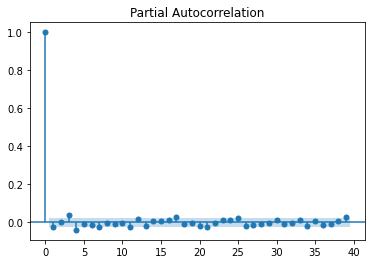

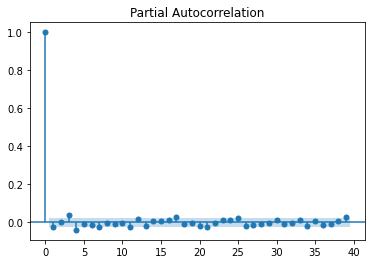

In [33]:
plot_pacf(first_df)

<details>
    <summary><font color = 'green'>Click once to check if you identified the right cut-off. No cheating!</font></summary>
    <div>
        <img src = 'https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/PACFLagTerm.png'>
    </div>
</details>

### Step 12: Plot ACF of first_diff data
After plotting PACF, we will then plot the ACF of the first_diff values to get our MA term (q).

Similarly, we're looking for the first x-value that falls within the blue box.

In [ ]:
# Step 12: Plot ACF with first_diff

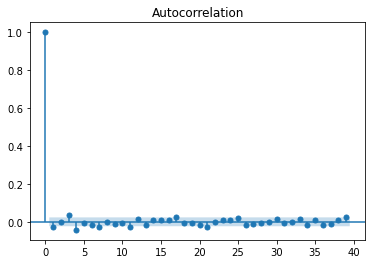

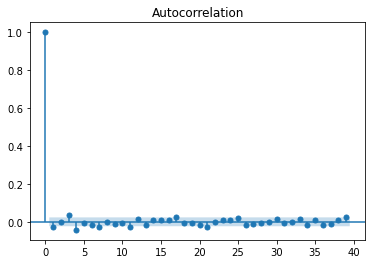

In [34]:
plot_acf(first_df)

<details>
    <summary><font color = 'green'>Click once to check if you identified the right x-value from the plot.</font></summary>
    <div>
        <strong>It's q=2. Did you get it right?</strong>
    </div>
</details>

## Modelling ARIMA model
Now that we have obtained our p, d, and q terms, we can now fit our data the ARIMA model with the terms. 

We'll be fitting our 'Open' data into the model with the p, d, and q terms. 

You might be wondering why we're using 'Open' and not 'first_diff' directly, it's because there is differencing done at d=1 so we were testing on the differenced data directly.

### Step 13: Split data into train and test
In the research paper, the authors split the data into train and test. 

- Train data: January 3 2000 to May 16 2019
- Test data: May 17 2019 to July 1 2019

Slice the DataFrame according to those dates, and assign them to two separate variables.

In [ ]:
# Step 13a: Split your DataFrame into train using the dates

In [ ]:
# Step 13b: Split your DataFrame into test using the dates

In [48]:
train=df_sp500_filled['2000-01-03' :'2019-05-16']
test=df_sp500_filled['2019-05-17' :'2019-07-01']

In [79]:
test

,Open,High,Low,Close,Adj Close,Volume,first_diff
Date,,,,,,,
2019-05-17,2858.600098,2885.479980,2854.229980,2859.530029,2859.530029,3257950000,2.800049
2019-05-18,2841.939941,2853.860107,2831.290039,2840.229980,2840.229980,3288870000,-16.660157
2019-05-19,2841.939941,2853.860107,2831.290039,2840.229980,2840.229980,3288870000,0.000000
2019-05-20,2841.939941,2853.860107,2831.290039,2840.229980,2840.229980,3288870000,0.000000
2019-05-21,2854.020020,2868.879883,2854.020020,2864.360107,2864.360107,3218700000,12.080079
2019-05-22,2856.060059,2865.469971,2851.110107,2856.270020,2856.270020,3192510000,2.040039
2019-05-23,2836.699951,2836.699951,2805.489990,2822.239990,2822.239990,3891980000,-19.360108
2019-05-24,2832.409912,2841.360107,2820.189941,2826.060059,2826.060059,2887390000,-4.290039
2019-05-25,2830.030029,2840.510010,2801.580078,2802.389893,2802.389893,4121410000,-2.379883


## Predict and plot
Now that we've obtained the three terms, i.e. p=2, d=1, q=2, and split our data, we can now fit the data and subsequently plot our predictions.

The documentation is helpful:
- General ARIMA: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA
- Fit method (take note of what is returned): https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.fit.html#statsmodels.tsa.arima.model.ARIMA.fit
- ARIMAResults object: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels.tsa.arima.model.ARIMAResults

### Step 14: Import ARIMA 
Let's import ARIMA from statsmodels.tsa.arima_model.

In [ ]:
# Step 14: Import ARIMA

In [49]:
from statsmodels.tsa.arima.model import ARIMA

### Step 15: Declare ARIMA model and fit train data
Declare a variable containing your ARIMA object. It should have two things:
- your train set's 'Open' price
- order parameter with (2,1,2)

After that, call the .fit method on the variable and assign the results to a new variable. 

That's because the .fit method returns an ARIMAResults object, and you can make forecasts using that object.

In [ ]:
# Step 15a: Declare an ARIMA model

In [ ]:
# Step 15b: Call .fit() on the variable and asign the results to the new variable

In [50]:
train_open=train['Open']

In [51]:
model = ARIMA(train_open, order=(2,1,2))

In [52]:
model_fit = model.fit()

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 7073
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -28060.026
Date:                Fri, 15 Jan 2021   AIC                          56130.052
Time:                        01:11:46   BIC                          56164.372
Sample:                    01-04-2000   HQIC                         56141.872
                         - 05-16-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1342      0.097    -11.703      0.000      -1.324      -0.944
ar.L2         -0.5242      0.100     -5.218      0.000      -0.721      -0.327
ma.L1          1.1018      0.100     11.054      0.0

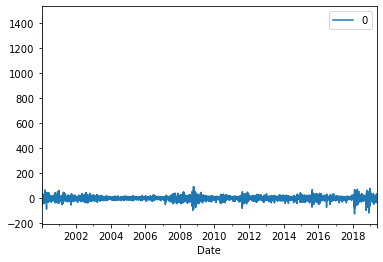

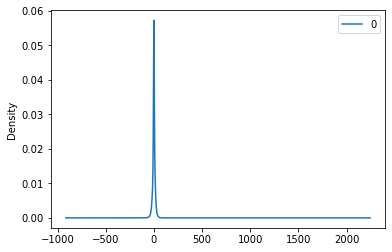

                 0
count  7073.000000
mean      0.409729
std      21.515440
min    -124.422537
25%      -2.737047
50%       0.100980
75%       4.449151
max    1455.219971


In [53]:
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

### Step 16: Get the ARIMA forecasts
It's time! Call the .forecast method on the ARIMAResults object you got from Step 15b. 

Take note of the <strong>steps</strong> parameter. If you call it as is, you'll only get 1 forecast. 

You need to add the <em>length of the test DataFrame</em> into the <strong>steps</strong> parameter.

Once you call the .forecast method with the steps, the method will return a tuple containing three items. 

The first item is what you want, i.e. an array containing your forecasts.

In [ ]:
# Step 16a: Call the .forecast method using the variable from Step 15b and assign the results into a variable

In [ ]:
# Step 16b: Assign the first item of the tuple into a variable

In [84]:
output= model_fit.forecast(steps=len(test))

In [92]:
output

2019-05-17    2854.178533
2019-05-18    2854.430645
2019-05-19    2854.994636
2019-05-20    2854.222801
2019-05-21    2854.802604
2019-05-22    2854.549551
2019-05-23    2854.532656
2019-05-24    2854.684460
2019-05-25    2854.521137
2019-05-26    2854.626810
2019-05-27    2854.592562
2019-05-28    2854.576017
2019-05-29    2854.612734
2019-05-30    2854.579761
2019-05-31    2854.597914
2019-06-01    2854.594608
2019-06-02    2854.588842
2019-06-03    2854.597115
2019-06-04    2854.590754
2019-06-05    2854.593632
2019-06-06    2854.593702
2019-06-07    2854.592114
2019-06-08    2854.593878
2019-06-09    2854.592710
2019-06-10    2854.593111
2019-06-11    2854.593269
2019-06-12    2854.592879
2019-06-13    2854.593238
2019-06-14    2854.593035
2019-06-15    2854.593077
2019-06-16    2854.593136
2019-06-17    2854.593047
2019-06-18    2854.593117
2019-06-19    2854.593084
2019-06-20    2854.593085
2019-06-21    2854.593101
2019-06-22    2854.593082
2019-06-23    2854.593095
2019-06-24  

<details>
    <summary><font color = 'green'>Click once to check if you got the right array.</font></summary>
    <div>
        <img src = 'https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/ForecastArray.png'>
    </div>
</details>

### Step 17: Create a Series for the forecast
The thing about the forecast array that you got is that it does not have an index that corresponds to the test DataFrame.

Create a Series object containing the forecast array, and use the index from the test DataFrame.

In [ ]:
# Step 17: Create a Series of the forecast

In [90]:
fc_series = pd.Series(output, index=test.index)

In [91]:
fc_series

Date
2019-05-17    2854.178533
2019-05-18    2854.430645
2019-05-19    2854.994636
2019-05-20    2854.222801
2019-05-21    2854.802604
2019-05-22    2854.549551
2019-05-23    2854.532656
2019-05-24    2854.684460
2019-05-25    2854.521137
2019-05-26    2854.626810
2019-05-27    2854.592562
2019-05-28    2854.576017
2019-05-29    2854.612734
2019-05-30    2854.579761
2019-05-31    2854.597914
2019-06-01    2854.594608
2019-06-02    2854.588842
2019-06-03    2854.597115
2019-06-04    2854.590754
2019-06-05    2854.593632
2019-06-06    2854.593702
2019-06-07    2854.592114
2019-06-08    2854.593878
2019-06-09    2854.592710
2019-06-10    2854.593111
2019-06-11    2854.593269
2019-06-12    2854.592879
2019-06-13    2854.593238
2019-06-14    2854.593035
2019-06-15    2854.593077
2019-06-16    2854.593136
2019-06-17    2854.593047
2019-06-18    2854.593117
2019-06-19    2854.593084
2019-06-20    2854.593085
2019-06-21    2854.593101
2019-06-22    2854.593082
2019-06-23    2854.593095
2019-06

### Step 18: Plot the forecast with the test data
Moment of truth, let's plot the forecast in the same plot as the test data.

Don't forget to refer to the research paper for comparison.

In [ ]:
# Step 18: Plot the forecast with test data

In [97]:
test['Open']

Date
2019-05-17    2858.600098
2019-05-18    2841.939941
2019-05-19    2841.939941
2019-05-20    2841.939941
2019-05-21    2854.020020
2019-05-22    2856.060059
2019-05-23    2836.699951
2019-05-24    2832.409912
2019-05-25    2830.030029
2019-05-26    2830.030029
2019-05-27    2830.030029
2019-05-28    2830.030029
2019-05-29    2790.250000
2019-05-30    2786.939941
2019-05-31    2766.149902
2019-06-01    2751.530029
2019-06-02    2751.530029
2019-06-03    2751.530029
2019-06-04    2762.639893
2019-06-05    2818.090088
2019-06-06    2828.510010
2019-06-07    2852.870117
2019-06-08    2885.830078
2019-06-09    2885.830078
2019-06-10    2885.830078
2019-06-11    2903.270020
2019-06-12    2882.729980
2019-06-13    2886.239990
2019-06-14    2886.820068
2019-06-15    2889.750000
2019-06-16    2889.750000
2019-06-17    2889.750000
2019-06-18    2906.709961
2019-06-19    2920.550049
2019-06-20    2949.600098
2019-06-21    2952.709961
2019-06-22    2951.419922
2019-06-23    2951.419922
2019-06

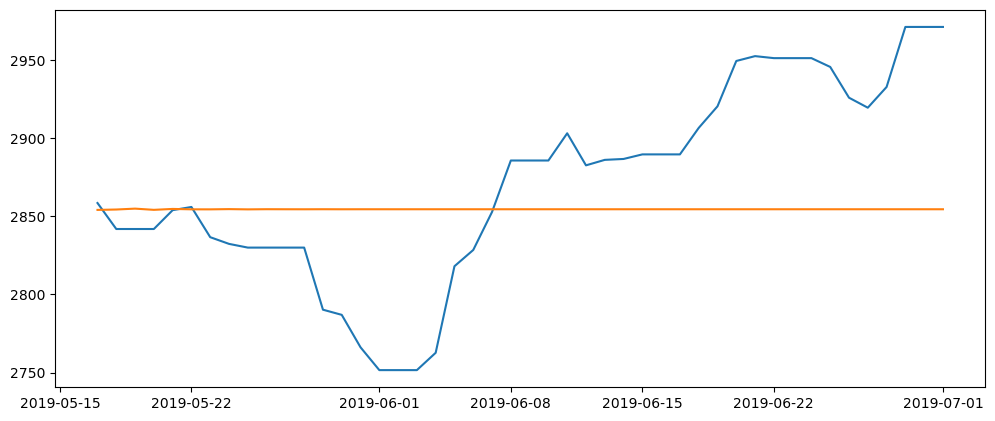

In [100]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test['Open'], label='actual')
plt.plot(fc_series,label='forecast')


<details>
    <summary><font color = 'green'>Click once to check if you got the plot.</font></summary>
    <div>
        <img src = 'https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/ARIMAForecastvsTest.png'>
    </div>
</details>

### End of Part II
In this Part, we performed ARIMA modelling to model the time series. The prediction ended up being a straight line because the data doesn't have strong seasonality. 

Don't be too discouraged! Is it a bad model? 

Not quite so since you see that the forecast direction is ok. Silver lining - this Part was a good way to practice the ARIMA technique. 

Next up in Part III, we will prepare the data for LSTM.